In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from typing import Any, Dict, List, Tuple
from omegaconf import DictConfig
import hydra
from hydra.core.hydra_config import HydraConfig
import torch
from lightning import LightningDataModule, LightningModule, Trainer
import rootutils
from torchmetrics.functional.classification import binary_confusion_matrix
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
from collections import defaultdict
import numpy as np
import lightning as L


In [4]:
rootutils.setup_root("/home/rick/hd2/aav_sequence_design", indicator=".project-root", pythonpath=True)
%env PROJECT_ROOT

'/home/rick/hd2/aav_sequence_design'

In [5]:
def initialize_hydra(config_path, config_name):
    if HydraConfig.initialized():
        hydra.core.global_hydra.GlobalHydra.instance().clear()
    hydra.initialize(version_base="1.3", config_path=config_path, job_name="notebook")
    cfg = hydra.compose(config_name=config_name, return_hydra_config=True)
    return cfg
cfg = initialize_hydra(config_path="../configs", config_name="train.yaml")

In [6]:
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)
model: LightningModule = hydra.utils.instantiate(cfg.model)


/home/rick/miniforge3/envs/pytorch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path="/home/rick/hd2/aav_sequence_design/logs/train/multiruns/2024-08-15_16-30-21/34_batch_512_dropout_0.026630001561057475_lr_0.0005551268893069074/checkpoints/epoch_epoch=004_val.loss_val/loss=0.3240.ckpt"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

In [8]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [9]:
trainer = Trainer()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rick/miniforge3/envs/pytorch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
trainer.test(model=model, datamodule=datamodule)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8587060570716858     │
│         test/loss         │    0.32743290066719055    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.32743290066719055, 'test/acc': 0.8587060570716858}]

In [10]:
predictions = trainer.predict(model=model, datamodule=datamodule)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [11]:
df = datamodule.dataframe
df.loc[:, "pred_prob"] = torch.concatenate(predictions)
df.loc[:,'pred_label'] = (df['pred_prob'] > 0.5).astype(int)
df.loc[:,'group'] = df['label'].astype(str) + df['pred_label'].astype(str)
df

,Unnamed: 0,seq,aav9_plasmid,aav9_virus,label,pred_prob,pred_label,group
0,5,QVSSVQ,15,78,1,0.958465,1,11
1,13,MHKEVS,12,64,1,0.896605,1,11
2,25,YDQKMT,12,80,1,0.819120,1,11
3,26,MFMDGD,28,106,1,0.979607,1,11
4,29,YGNMHM,12,0,0,0.763019,1,01
...,...,...,...,...,...,...,...,...
2992622,30569213,YYYYSY,13,0,0,0.018713,0,00
2992623,30569229,YYYYWI,12,0,0,0.013490,0,00
2992624,30569230,YYYYWL,16,0,0,0.012643,0,00
2992625,30569234,YYYYYH,11,0,0,0.015103,0,00


<Figure size 640x480 with 0 Axes>

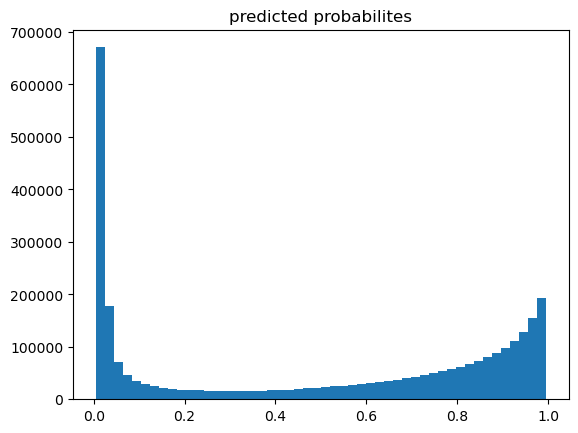

<Figure size 640x480 with 0 Axes>

In [12]:
plt.hist(df['pred_prob'], 50);
plt.title("predicted probabilites")
plt.figure() 

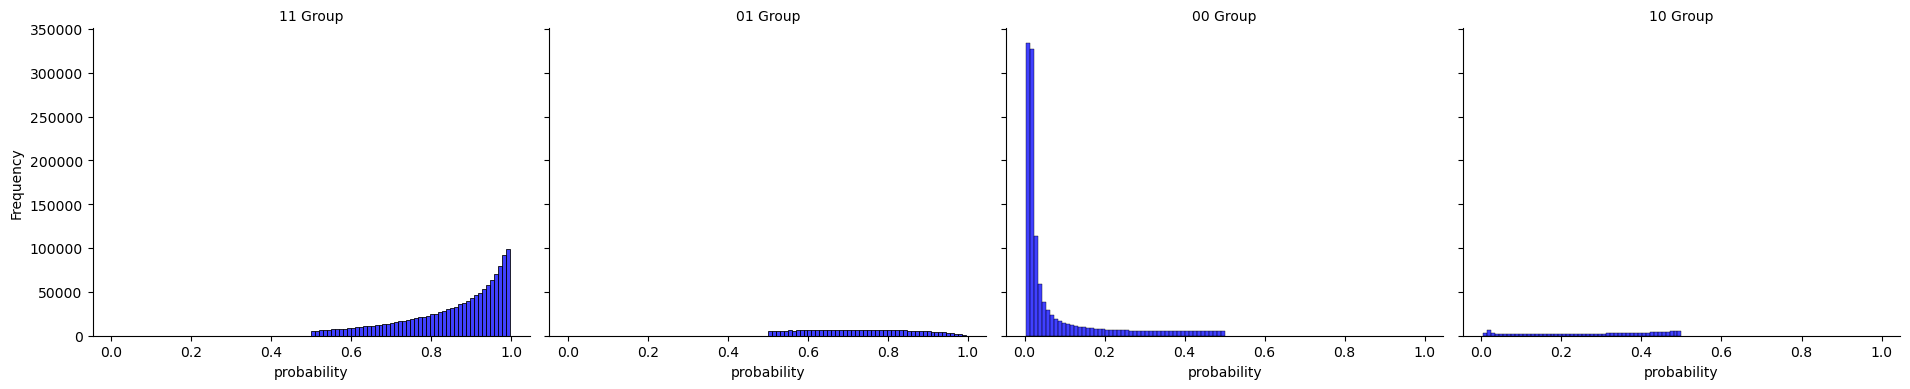

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Create a FacetGrid for the histogram
g = sns.FacetGrid(df, col="group", height=4, aspect=1.2)
g.map(sns.histplot, "pred_prob", bins=50, kde=False, color='blue')

# Set titles and labels
g.set_titles("{col_name} Group")
g.set_axis_labels("probability", "Frequency")

# Show the plot
plt.show()

In [14]:
binary_confusion_matrix(torch.tensor(df['pred_prob'].values), torch.tensor(df['label'].values), normalize = "all" )

tensor([[0.4158, 0.0930],
        [0.0449, 0.4463]])

In [26]:
x=datamodule.data_val[0][0].unsqueeze(0).float()
model_fwd = lambda: model(x)
fwd_flops = L.fabric.utilities.measure_flops(model, model_fwd)
fwd_flops

1098960

In [27]:
model_loss = lambda y: y.sum()
fwd_and_bwd_flops = L.fabric.utilities.measure_flops(model, model_fwd, model_loss)
fwd_and_bwd_flops

3210480

In [10]:
for name, param in model.named_parameters():
 print(f'Layer: {name}, Size: {param.size()}')

Layer: net.encoder.0.self_attn.in_proj_weight, Size: torch.Size([360, 120])
Layer: net.encoder.0.self_attn.out_proj.weight, Size: torch.Size([120, 120])
Layer: net.encoder.0.linear1.weight, Size: torch.Size([2048, 120])
Layer: net.encoder.0.linear2.weight, Size: torch.Size([120, 2048])
Layer: net.encoder.0.norm1.weight, Size: torch.Size([120])
Layer: net.encoder.0.norm2.weight, Size: torch.Size([120])
Layer: net.fc.weight, Size: torch.Size([1, 120])


In [22]:
enc_linear2_weights = model.net.encoder[0].linear2.weight.detach().cpu().numpy()
enc_linear2_weights.shape

(120, 2048)

In [34]:
fc_weights = model.net.fc.weight.detach().cpu().numpy()
fc_weights.shape

(1, 120)

In [16]:
enc_attention_weights = model.net.encoder[0].self_attn.out_proj.weight.detach().cpu().numpy()
enc_attention_weights.shape

(120, 120)

In [44]:
SEQ_LEN=6
numbers = range(1, SEQ_LEN+1)
amino_acid_list = datamodule.data_val.dataset.amino_acid_list

feature_names=[]
# Iterate through each letter and number combination
for number in numbers:
    for  amino_acid in amino_acid_list:
        feature_name=amino_acid + str(number)
        feature_names.append(feature_name)
len(feature_names)

120

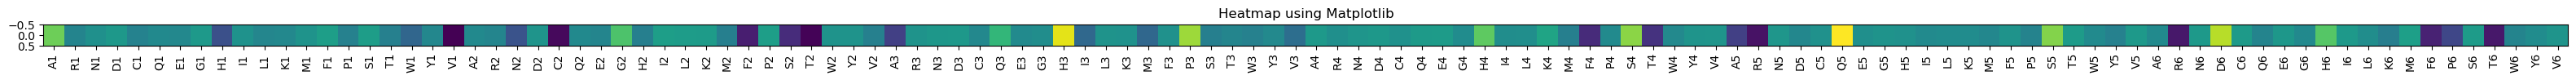

In [36]:
dim_mat=20*6
plt.figure(figsize=(40, 20)) 
plt.imshow(fc_weights, cmap='viridis', interpolation='nearest')
#plt.colorbar( )
plt.title('Heatmap using Matplotlib')
plt.xticks(ticks=list(range(dim_mat)), rotation=90, labels=feature_names)
plt.show()

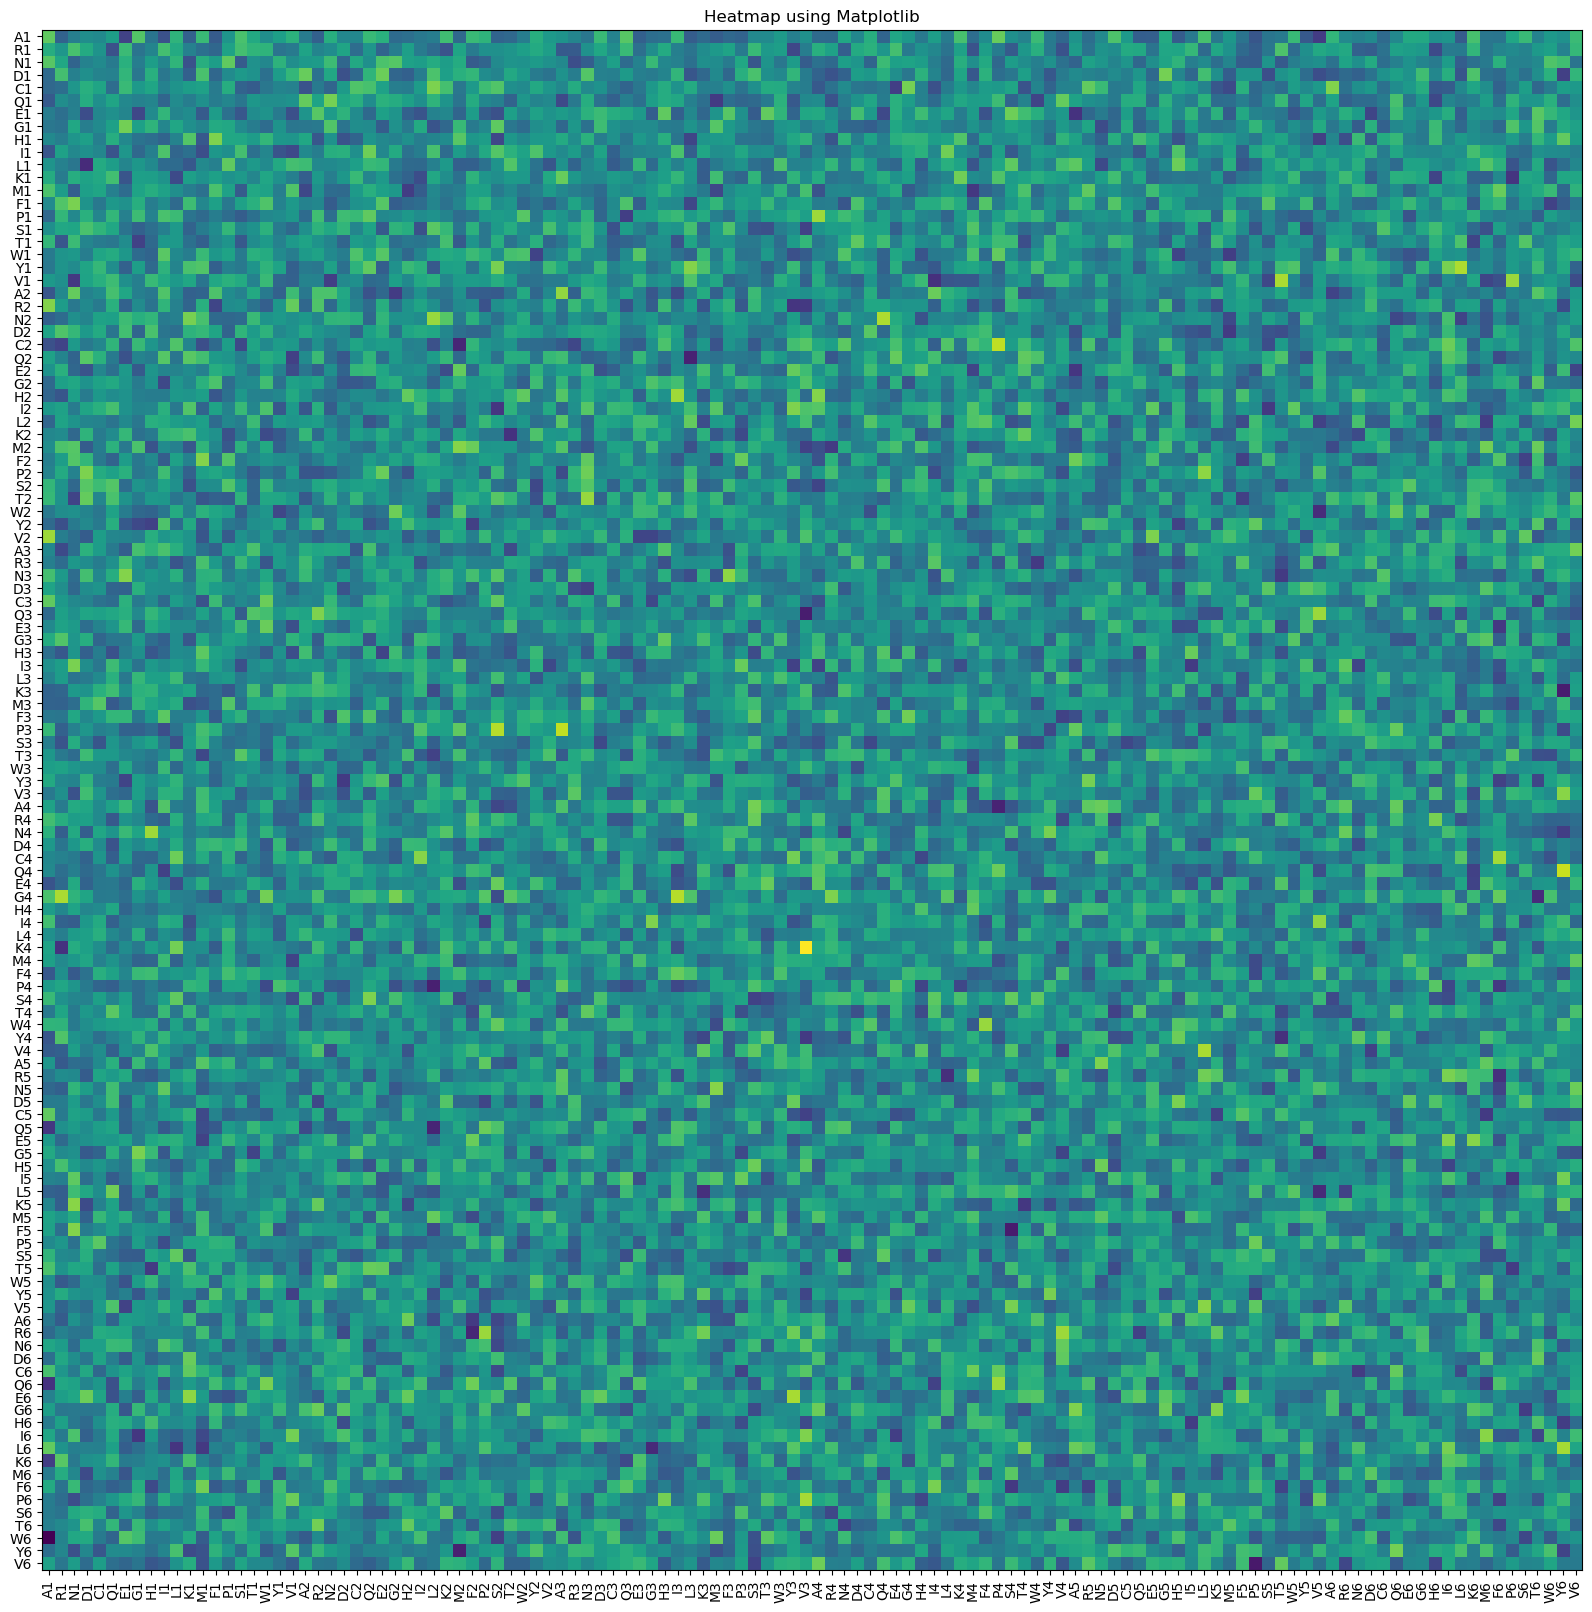

In [24]:
dim_mat=20*6
plt.figure(figsize=(40, 20)) 
plt.imshow(enc_attention_weights.T, cmap='viridis', interpolation='nearest')
#plt.colorbar( )
plt.title('Heatmap using Matplotlib')
plt.yticks(ticks=list(range(dim_mat)), labels=feature_names)
plt.xticks(ticks=list(range(dim_mat)), rotation=90, labels=feature_names)
plt.show()

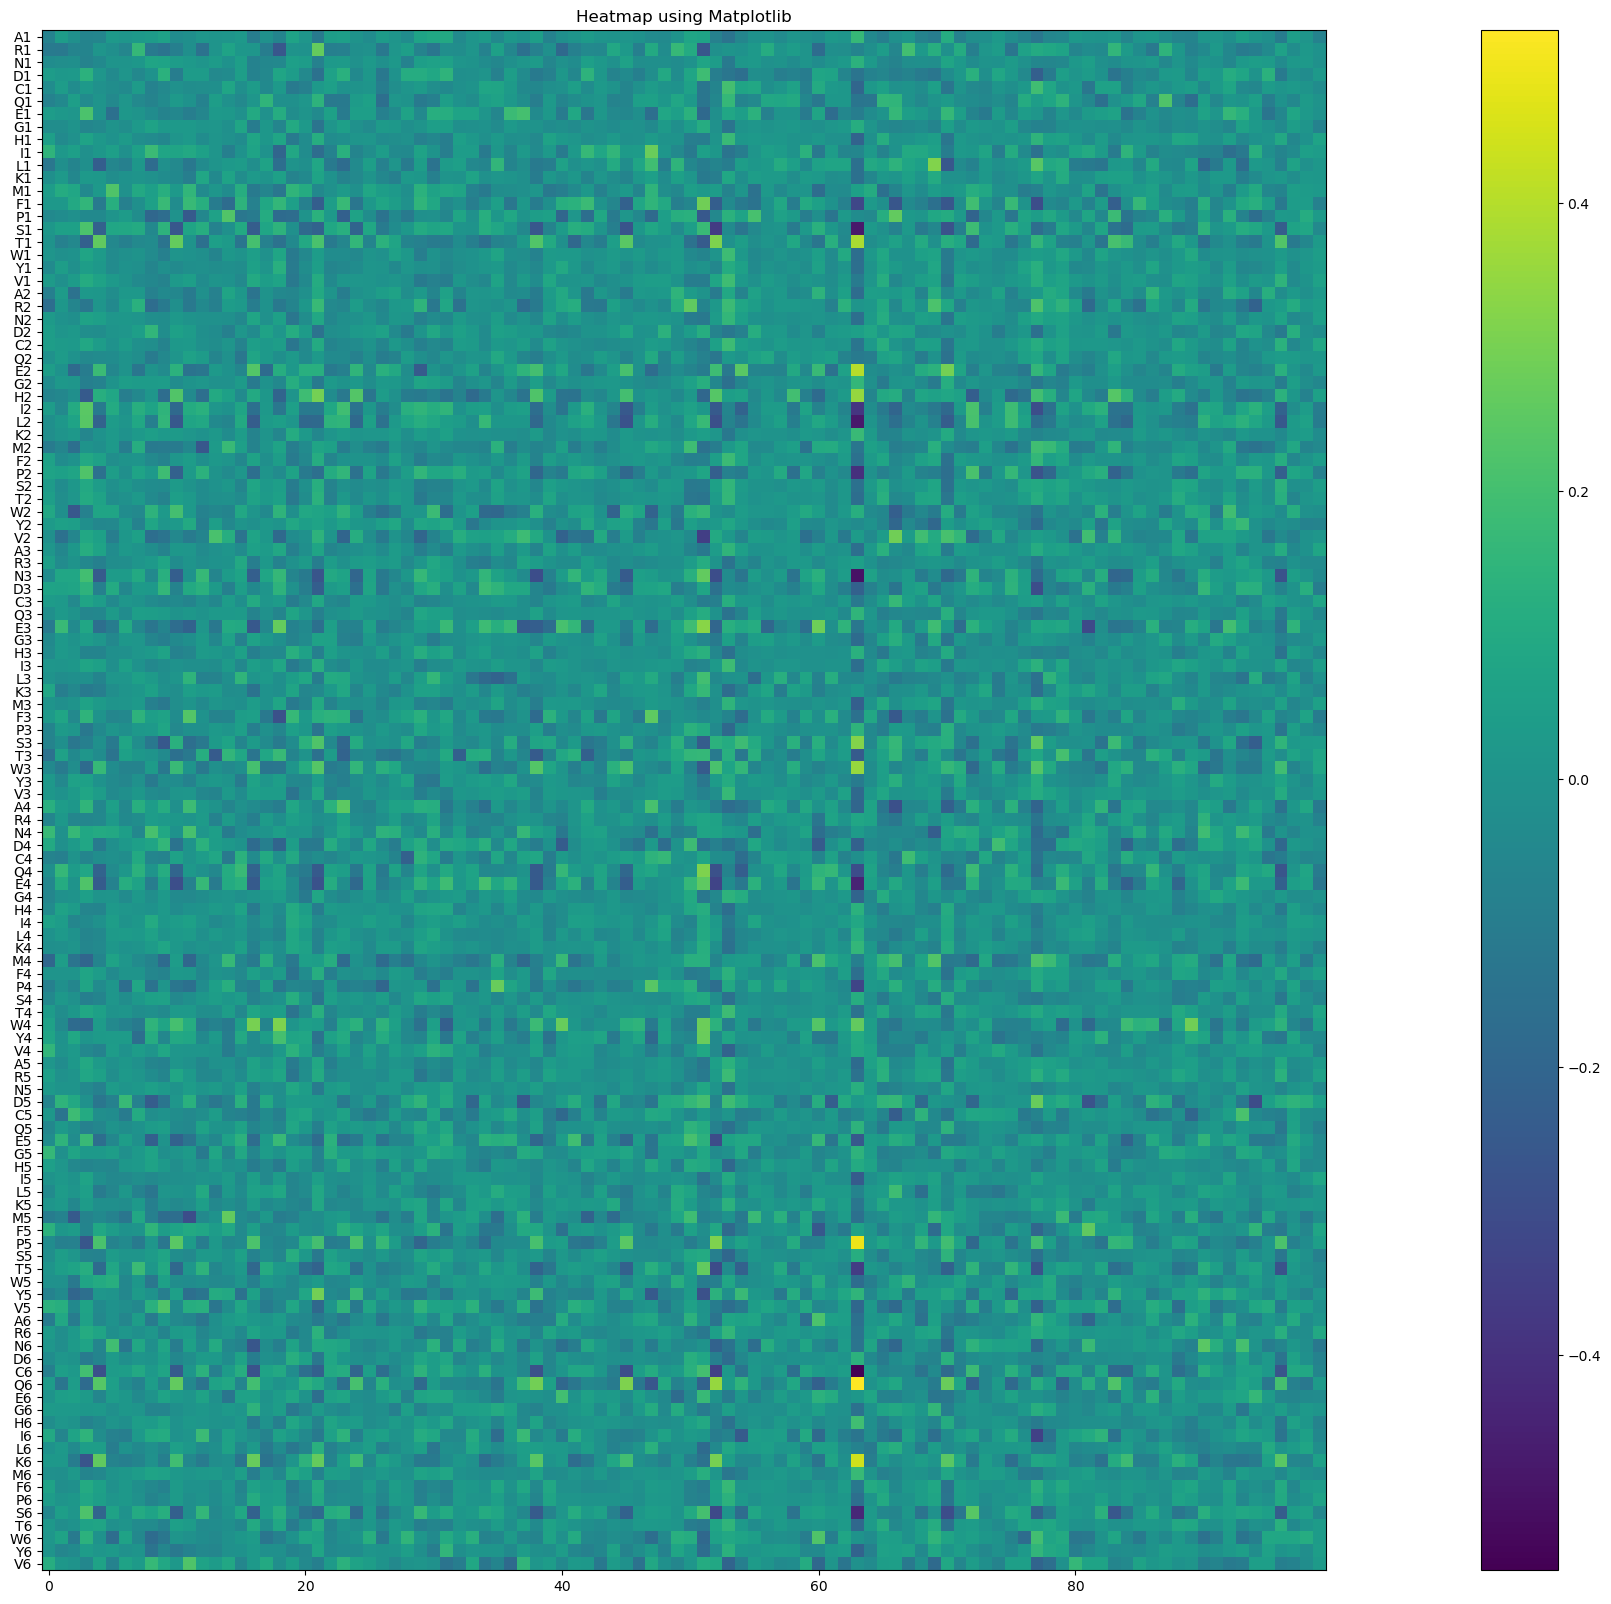

In [37]:
plt.figure(figsize=(40, 20)) 
plt.imshow(enc_linear2_weights[:, 0:100], cmap='viridis', interpolation='nearest')
plt.colorbar( )
plt.title('Heatmap using Matplotlib')
plt.yticks(ticks=list(range(dim_mat)), labels=feature_names)
#plt.xticks(ticks=list(range(dim_mat)), rotation=90, labels=feature_names)
plt.show()

Interpertable ML

In [12]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(14,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names,rotation=90)
        plt.xlabel(axis_title)
        plt.title(title)

In [13]:
result_list = [datamodule.data_test[i][0].unsqueeze(0).float() for i in range(len(datamodule.data_test))]
test_input_tensor = torch.cat(result_list, dim=0)
test_input_tensor.requires_grad_()

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [14]:
ig = IntegratedGradients(model)

In [15]:
cond = LayerConductance(model, model.net.encoder[0].norm2)

In [36]:
neuron_cond = NeuronConductance(model, model.net.encoder[0].norm2)

In [16]:
cond_vals_1 = cond.attribute(test_input_tensor[0:100,:],target=0)
cond_vals_1 = cond_vals_1.detach().numpy()

In [17]:
cond_vals = cond.attribute(test_input_tensor[0:1000,:],target=0)
cond_vals = cond_vals.detach().numpy()

In [18]:
import gc

gc.collect()  

0

In [94]:
cond_vals_1.shape

(99, 120)

Average Neuron Importances
0 :  0.085
1 :  0.016
2 :  -0.000
3 :  0.004
4 :  0.001
5 :  -0.001
6 :  0.001
7 :  0.006
8 :  0.055
9 :  -0.004
10 :  0.006
11 :  0.005
12 :  -0.003
13 :  0.005
14 :  -0.001
15 :  0.011
16 :  0.012
17 :  0.029
18 :  0.001
19 :  0.195
20 :  0.003
21 :  0.003
22 :  0.060
23 :  0.001
24 :  0.198
25 :  0.000
26 :  0.005
27 :  0.059
28 :  -0.006
29 :  0.007
30 :  0.007
31 :  0.000
32 :  -0.011
33 :  0.157
34 :  0.002
35 :  0.115
36 :  0.209
37 :  0.001
38 :  0.002
39 :  -0.001
40 :  0.109
41 :  0.000
42 :  0.009
43 :  0.002
44 :  0.002
45 :  0.001
46 :  -0.002
47 :  0.000
48 :  0.171
49 :  0.018
50 :  -0.002
51 :  -0.002
52 :  0.012
53 :  -0.002
54 :  0.130
55 :  0.008
56 :  -0.002
57 :  0.020
58 :  -0.001
59 :  0.016
60 :  -0.007
61 :  -0.000
62 :  0.002
63 :  0.006
64 :  -0.003
65 :  0.003
66 :  0.004
67 :  -0.001
68 :  0.067
69 :  0.000
70 :  0.000
71 :  0.011
72 :  0.006
73 :  0.081
74 :  -0.001
75 :  0.144
76 :  0.107
77 :  -0.000
78 :  0.007
79 :  -0.001
80

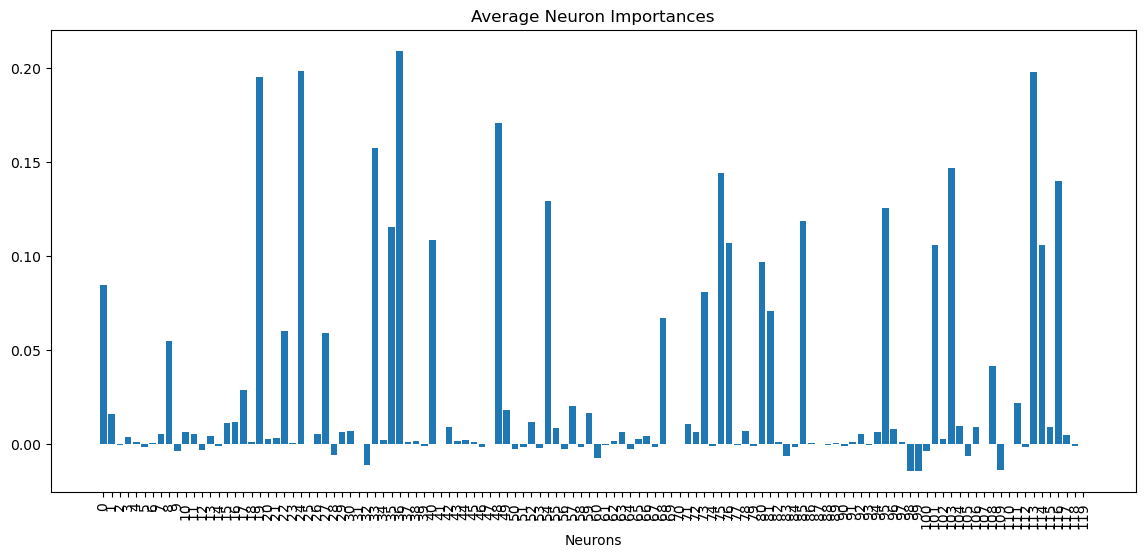

In [19]:
visualize_importances(range(120),np.mean(cond_vals_1, axis=0),title="Average Neuron Importances", axis_title="Neurons")

Average Neuron Importances
0 :  0.104
1 :  0.019
2 :  -0.000
3 :  0.008
4 :  -0.002
5 :  0.002
6 :  0.001
7 :  0.007
8 :  0.048
9 :  -0.002
10 :  0.013
11 :  0.004
12 :  -0.004
13 :  0.022
14 :  -0.005
15 :  0.030
16 :  0.030
17 :  0.029
18 :  0.005
19 :  0.167
20 :  0.003
21 :  0.001
22 :  0.059
23 :  0.002
24 :  0.168
25 :  0.001
26 :  0.007
27 :  0.079
28 :  0.010
29 :  0.027
30 :  0.034
31 :  0.002
32 :  0.003
33 :  0.116
34 :  0.026
35 :  0.119
36 :  0.184
37 :  0.004
38 :  0.002
39 :  0.005
40 :  0.105
41 :  0.000
42 :  0.019
43 :  0.008
44 :  0.005
45 :  0.014
46 :  -0.001
47 :  0.000
48 :  0.180
49 :  0.033
50 :  -0.001
51 :  -0.001
52 :  0.016
53 :  -0.002
54 :  0.128
55 :  0.012
56 :  -0.002
57 :  0.036
58 :  0.001
59 :  0.024
60 :  0.003
61 :  -0.000
62 :  0.004
63 :  0.014
64 :  -0.003
65 :  0.012
66 :  0.016
67 :  -0.001
68 :  0.072
69 :  0.000
70 :  0.000
71 :  0.009
72 :  0.015
73 :  0.102
74 :  -0.001
75 :  0.131
76 :  0.106
77 :  0.002
78 :  0.008
79 :  0.002
80 :  0.0

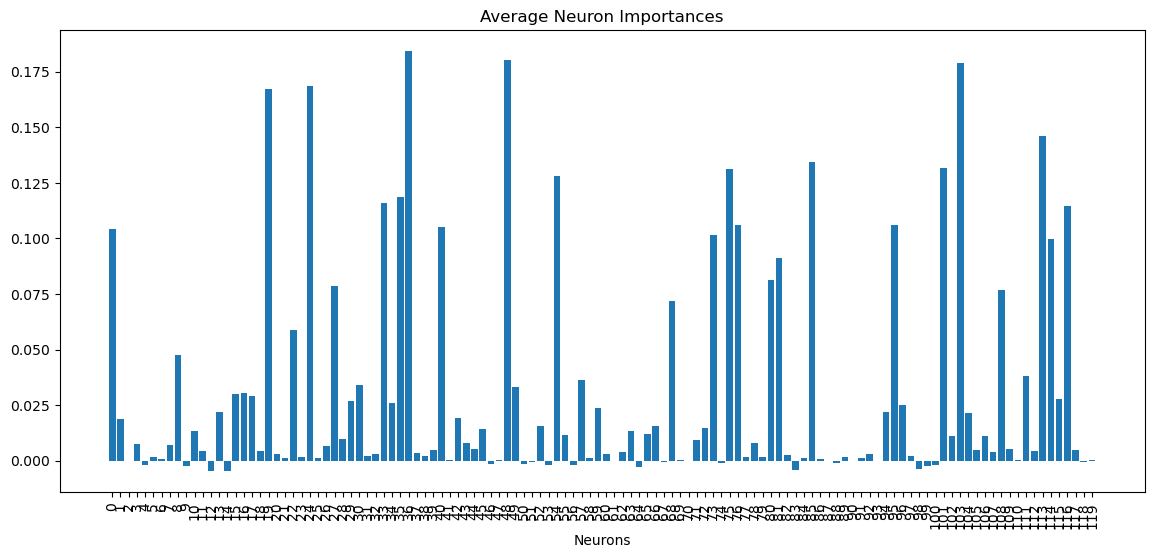

In [20]:
visualize_importances(range(120),np.mean(cond_vals[0:100,:], axis=0),title="Average Neuron Importances", axis_title="Neurons")

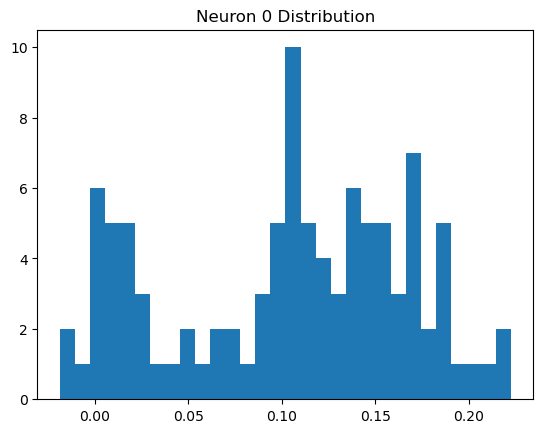

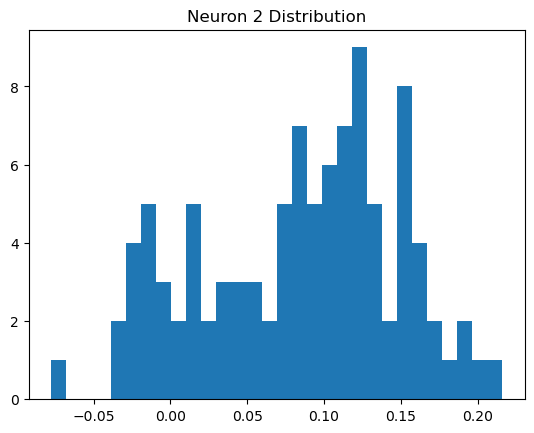

In [27]:
plt.hist(cond_vals[0:100,0], 30);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals_1[:,0], 30);
plt.title("Neuron 2 Distribution");

In [71]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor[1:1000,:], neuron_selector=1, target=0)

Average Feature Importances for Neuron 10
A1 :  -0.000
R1 :  -0.004
N1 :  -0.000
D1 :  0.001
C1 :  -0.000
Q1 :  -0.003
E1 :  -0.000
G1 :  0.000
H1 :  0.001
I1 :  0.000
L1 :  -0.001
K1 :  -0.001
M1 :  -0.002
F1 :  0.000
P1 :  0.000
S1 :  0.000
T1 :  0.000
W1 :  -0.001
Y1 :  0.001
V1 :  0.001
A2 :  -0.000
R2 :  -0.000
N2 :  0.000
D2 :  0.000
C2 :  0.000
Q2 :  -0.001
E2 :  0.001
G2 :  0.001
H2 :  -0.000
I2 :  -0.000
L2 :  0.000
K2 :  0.000
M2 :  -0.001
F2 :  0.000
P2 :  -0.000
S2 :  0.001
T2 :  0.000
W2 :  0.001
Y2 :  -0.000
V2 :  -0.001
A3 :  0.000
R3 :  -0.000
N3 :  -0.000
D3 :  0.000
C3 :  -0.000
Q3 :  -0.000
E3 :  0.001
G3 :  0.001
H3 :  0.000
I3 :  0.000
L3 :  -0.000
K3 :  -0.000
M3 :  -0.001
F3 :  -0.000
P3 :  0.001
S3 :  -0.000
T3 :  0.000
W3 :  -0.001
Y3 :  -0.001
V3 :  0.000
A4 :  0.000
R4 :  -0.000
N4 :  0.000
D4 :  -0.000
C4 :  -0.000
Q4 :  0.000
E4 :  0.000
G4 :  0.000
H4 :  -0.000
I4 :  0.000
L4 :  0.000
K4 :  -0.000
M4 :  -0.000
F4 :  0.000
P4 :  -0.000
S4 :  0.000
T4 :  0.0

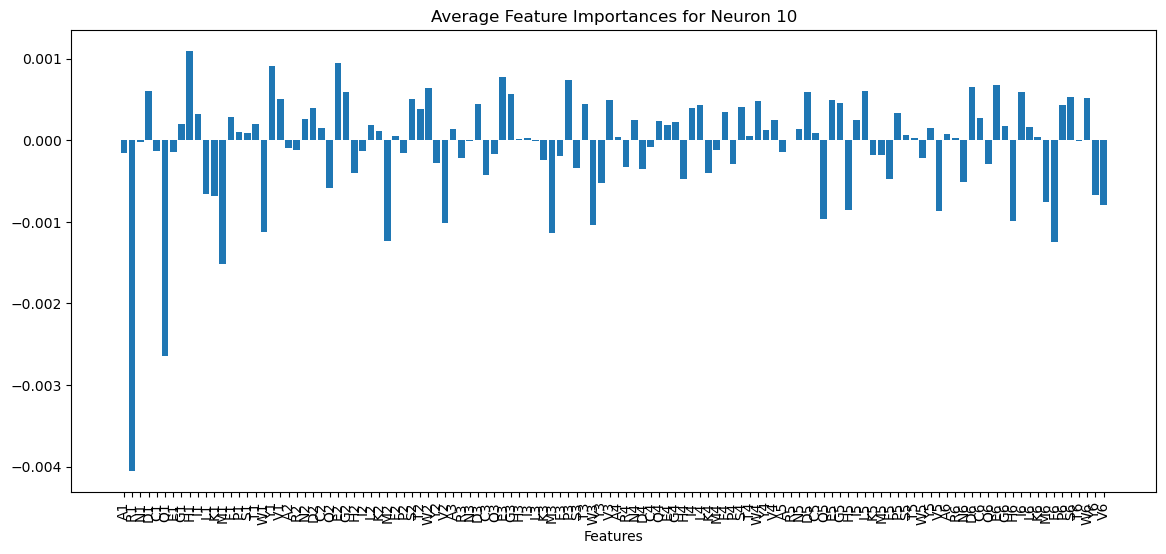

In [72]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")

In [ ]:
neuron_cond_vals= defaultdict(list)
for i in range(5):
    attris=[]
    for input in test_input_tensor:
        input= input.unsqueeze(0)
        attri = neuron_cond.attribute(input, neuron_selector=i, target=1)
        attris.append(attri.cpu())
    attris=torch.cat(attris, dim=0)
    neuron_cond_vals[i].append(attris.detach().numpy())  

In [ ]:
max_obs=100
neuron_pos= 4
data_plot=neuron_cond_vals[neuron_pos][0][0:max_obs,:].T
y_dim=data_plot.shape[0]
x_dim=data_plot.shape[1]
obs_labels= test_dataset['seq'].values[0:max_obs].tolist()
plt.figure(figsize=(40, 15)) 
plt.imshow(data_plot, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap using Matplotlib')
plt.yticks(ticks=list(range(y_dim)), labels=feature_names )
plt.xticks(ticks=list(range(x_dim)), labels=obs_labels, rotation=90 )
plt.show()

In [3]:
from typing import Any, Dict, List, Tuple
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.loggers import Logger
from omegaconf import DictConfig, OmegaConf
import torch
from dataset_module import SeqDatasetModule
from classification_attention_model import SequenceEncoder
import os
import lightning as L

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

In [ ]:
arr = enc_attention_weights[120:240,:].T

mask = (arr > 1) | (arr < -1)
row_indices = np.where(mask.any(axis=1))[0]

In [69]:
import re
MOTIFS= ['C...C.']
def find_motif(seq):
    # negative matching is first (presence of low fitness motif preculdes further enrichment) 
    for motif in MOTIFS:
        if re.match(motif, seq):
            return  motif 

In [70]:
out= list(map( find_motif, test_dataset["seq"].values))

filtered_df = test_dataset[[x is not None for x in out]]
filtered_df 

,seq,aav9_plasmid,aav9_virus,label,pred_prob,pred_label,hit,acc,split
1500,CSGICY,5,1426,1,0.326992,0,False,0.714286,test
10771,CFEQCM,11,632,1,0.718770,1,True,0.760708,test
16970,CRMYCN,10,550,1,0.091057,0,False,0.777603,test
21626,CSRTCK,4,513,1,0.044005,0,False,0.781497,test
30272,CVPCCV,9,466,1,0.448921,0,False,0.789093,test
...,...,...,...,...,...,...,...,...,...
20892074,CLVCCM,8,0,0,0.051073,0,True,0.812072,test
20892258,CIFKCR,4,0,0,0.044901,0,True,0.812071,test
20892414,CRQQCM,8,0,0,0.082223,0,True,0.812074,test
20892625,CWYCCI,5,0,0,0.031148,0,True,0.812070,test


In [73]:
filtered_df.groupby("label").count()


,seq,aav9_plasmid,aav9_virus,pred_prob,pred_label,hit,acc,split
label,,,,,,,,
0,14863,14863,14863,14863,14863,14863,14863,14863
1,4282,4282,4282,4282,4282,4282,4282,4282


In [33]:
# Create a sample NumPy array
array = neuron_cond_vals[4][0]

# Step 1: Compute the absolute values of the array
abs_array = np.abs(array)

# Step 2: Find the indices of the top 3 largest absolute values for each row
k = 2
top_k_indices = np.argpartition(abs_array, -k, axis=1)[:, -k:]

# Step 3: Sort these indices to get them in the correct order
sorted_top_k_indices = np.array([row[np.argsort(abs_array[i, row])][::-1] for i, row in enumerate(top_k_indices)])
result = np.array([''.join(feature_names[idx] for idx in row) for row in sorted_top_k_indices])
result


array(['F5D4', 'F2C1', 'D4N5', ..., 'W3S2', 'D3F4', 'A5M4'], dtype='<U4')

In [34]:
test_dataset["n1"]=result

In [69]:
sorted_top_k_indices

array([[38, 93],
       [92,  4],
       [11, 38],
       ...,
       [57, 35],
       [43, 73],
       [ 1, 80]])

In [ ]:
plt.hist(neuron_cond_vals[4][0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()

In [12]:
ig = IntegratedGradients(best_model)

In [ ]:
attr, delta = ig.attribute(test_input_tensor, target=0, return_convergence_delta=True)
attr = attr.detach().numpy()

In [ ]:
plt.hist(attr[1,:], 10);

In [ ]:
max_obs=100
data_plot=attr[0:max_obs,:].T
y_dim=data_plot.shape[0]
x_dim=data_plot.shape[1]
obs_labels= test_dataset['seq'].values[0:max_obs].tolist()
plt.figure(figsize=(40, 15)) 
plt.imshow(data_plot, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap using Matplotlib')
plt.yticks(ticks=list(range(y_dim)), labels=feature_names )
plt.xticks(ticks=list(range(x_dim)), labels=obs_labels, rotation=90 )
plt.show()

In [ ]:
max_obs=200
data_plot=cond_vals[0:max_obs,:].T
y_dim=data_plot.shape[0]
x_dim=data_plot.shape[1]
obs_labels= test_dataset['seq'].values[0:max_obs].tolist()
plt.figure(figsize=(40, 15)) 
plt.imshow(data_plot, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap using Matplotlib')
plt.yticks(ticks=list(range(y_dim)), labels=feature_names )
plt.xticks(ticks=list(range(x_dim)), labels=obs_labels, rotation=90 )
plt.show()

In [ ]:
def mark_train_test_split(df):
    indices = np.arange(df.shape[0])
    # Split the indices
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=24)
    df['test'] = 0
    df.loc[test_indices, 'test'] = 1
    return df

def split_df(df):
    test_df= df[df['test'] == 1]
    test_df = test_df.drop(columns=['test'])
    train_df= df[df['test'] == 0]
    train_df = train_df.drop(columns=['test'])
    return train_df, test_df

In [ ]:

numbers = range(1, 5)
colnames=[]
# Iterate through each letter and number combination
for number in numbers:
    for letter in amino_acid_list:
        colname=letter + str(number)
        colnames.append(colname)      

In [ ]:
enc_attention_weights = model.transformer_encoder.layers[0].linear2.weight.detach().cpu().numpy()
enc_attention_weights 